1. open pdf or collection
2. format text of pdf - make ready for embedding model
3. embed all chunks of text in pdf and turn them into numerical representations(embedding) - store for later
4. Build retrieval system - using vector search to find relevant chunk of text based on query
5. create prompt that incorporates retrieved pieces - augment
6. generate answer to query

1. 1-3 -> document preprocessing and embedding creation
2. 4-6 - search and answer

In [1]:
# pdf documents of choice
# embedding model of choice
                                                                                                                                        
# steps:
# 1. import pdf
# 2. process text for embedding (split into chunks)
# 3. embed text chunks
# 4. save embeddings to file for later

In [2]:
import os
import requests # to download things from internet

# get pdf document
pdf_path = "human-nutrition-text.pdf"

# download pdf
if not os.path.exists(pdf_path):
    print(f"[INFO] file does not exist...")

    # enter URL of PDF (download_url)
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    # local file name to save downloaded file
    filename = pdf_path

    # send GET request to URL
    response = requests.get(url)

    # check if request is succesful
    if response.status_code == 200:
        # open the file and save
        with open(filename, "wb") as file:
            file.write(response.content)

        print(f"[INFO] the file has been downloaded and saved as {filename}")\
    
    else:
        print(f"[INFO] failed to download the file. Status code: {response.status_code}")

else:
    print(f"file {pdf_path} exists.")

file human-nutrition-text.pdf exists.


In [3]:
# open pdf

## experiment with options here - better output formattings?
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """
    performs minor formatting on text
    """
    # Remove unnecessary whitespace
    text = ' '.join(text.split())
    # Replace line breaks with spaces
    cleaned_text = text.replace('\n', ' ')
    
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page number": page_number - 41, # adjusted as page 1 starts on 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4, # 1 token = ~4 characters as per open ai
                                "text": text})
    
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)

0it [00:00, ?it/s]

In [4]:
pages_and_texts[:2]

[{'page number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [5]:
pages_and_texts[42:43]

[{'page number': 1,
  'page_char_count': 88,
  'page_word_count': 16,
  'page_sentence_count_raw': 3,
  'page_token_count': 22.0,
  'text': 'PART I CHAPTER 1. BASIC CONCEPTS IN NUTRITION Chapter 1. Basic Concepts in Nutrition | 1'}]

In [6]:
import random
# read random pages
random.sample(pages_and_texts, k=3)

[{'page number': 242,
  'page_char_count': 1684,
  'page_word_count': 246,
  'page_sentence_count_raw': 16,
  'page_token_count': 421.0,
  'text': 'chemically broken down into single sugar units they are then transported into the inside of intestinal cells. When people do not have enough of the enzyme lactase, lactose is not sufficiently broken down resulting in a condition called lactose intolerance. The undigested lactose moves to the large intestine where bacteria are able to digest it. The bacterial digestion of lactose produces gases leading to symptoms of diarrhea, bloating, and abdominal cramps. Lactose intolerance usually occurs in adults and is associated with race. The National Digestive Diseases Information Clearing House states that African Americans, Hispanic Americans, American Indians, and Asian Americans have much higher incidences of lactose intolerance while those of northern European descent have the least.1 Most people with lactose intolerance can tolerate some amou

In [7]:
# Performing EDA on our text
# size of texts will help us better understand how to split the texts

# why we care about token count
# note: Many embedding models have limits on the size of texts they can ingest, 
# for example, the sentence-transformers model all-mpnet-base-v2 has an input size of 384 tokens.

# so if a text piece is over 384 tokens (384 * 4 chars) - the encoding will be reduced to 384 tokens - potential loss of information
# embedding models both don't deal with infinite tokens

# LLMs cannot accept infinite tokens in their context window

In [8]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,308,42,1,77.00,Human Nutrition: 2020 Edition UNIVERSITY OF HA...
3,-38,210,30,1,52.50,Human Nutrition: 2020 Edition by University of...
4,-37,766,116,3,191.50,Contents Preface University of Hawai‘i at Māno...


In [9]:
df.describe().round(2)

,page number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1120.50,171.99,10.52,280.12
std,348.86,551.86,86.44,6.55,137.97
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,741.50,109.00,5.00,185.38
50%,562.50,1191.50,183.00,10.00,297.88
75%,864.25,1572.25,239.00,15.00,393.06
max,1166.00,2271.00,393.00,39.00,567.75


We can break text into chunks of sentences.
Flow: ingest text -> split into chunks or groups -> embed groups/chunks -> use embeddings

NOTE - we can experiment with embeding models

We can split into sentences using split(". ") or using NLP - spaCy

In [10]:
from spacy.lang.en import English

In [11]:
nlp = English()

# add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# create a document instance (spacy) for example
doc = nlp("This is a sentence. This is another sentence. Are we even real?")
assert len(list(doc.sents)) == 3

# access the list of sentences of the document
list(doc.sents)

[This is a sentence., This is another sentence., Are we even real?]

In [12]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # defualt type is spacy datatype so make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # count sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
random.sample(pages_and_texts, k=1)

[{'page number': 690,
  'page_char_count': 762,
  'page_word_count': 114,
  'page_sentence_count_raw': 6,
  'page_token_count': 190.5,
  'text': 'Table 1: Dietary Reference Intakes for Manganese Age group AI (mg/day) UL (mg/day) Infants (0-6 months) 0.003 – Infants (6-12 months) 0.6 – Children (1-3 years) 1.2 2 Children (4-8 years) 1.5 3 Children (9-13 years) 1.9 6 Adolescents (14-18 years) 2.2 (males), 1.6 (females) 9 Adults (>18 years) 2.3 (males), 1.8 (females) 11 Source: The National Academies Press (2006). Dietary Reference Intakes: The Essential Guide to Nutrient Requirements. The National Academies of Sciences Engineering Medicine. 350. Dietary Sources of Manganese: The best food sources for manganese are whole grains, nuts, legumes, and green vegetables. Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook 690 | Manganese',
  'sentences': ['Table 1: Dietary Reference Intakes for Manganese Age group AI (mg/day) U

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1120.50,171.99,10.52,280.12,10.32
std,348.86,551.86,86.44,6.55,137.97,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,741.50,109.00,5.00,185.38,5.00
50%,562.50,1191.50,183.00,10.00,297.88,10.00
75%,864.25,1572.25,239.00,15.00,393.06,15.00
max,1166.00,2271.00,393.00,39.00,567.75,28.00


### chunking sentences together
The concept of splititng larger pieces of text into smaller ones is ofeten refered to as text splititng or chunking
Why chunking?
1. easier to manage small sized chunks
2. don't overload embedding models capacity for tokens - prevent info loss due to limited tokens
3. LLM context window maybe limited

for this we are sticking to groups of 10 sentences - arbitrary and can be changed - fits within 384 tokens

On average each of our pages has 10 sentences.

And an average total of 287 tokens per page.

So our groups of 10 sentences will also be ~287 tokens long.

In [15]:
num_sentence_chunk_size = 10

# splitting function that recursively splits a list into desired sizes

def split_list(input_list: list, slice_size: int) -> list[list[str]]:
    """
    split input_list into sublists of slice_size so [25] becomes [10][10][5]
    """
    return [input_list[i:i + slice_size] for i in range (0, len(input_list), slice_size)]
    

In [16]:
test = list(range(25))
out = split_list(test, num_sentence_chunk_size)
out

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [17]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list = item["sentences"],
                                         slice_size = num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [18]:
random.sample(pages_and_texts, k = 1)

[{'page number': 160,
  'page_char_count': 476,
  'page_word_count': 66,
  'page_sentence_count_raw': 4,
  'page_token_count': 119.0,
  'text': 'Thermoregul ation is the ability of an organism to maintain body temperature despite changing environment al temperatures . Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities. These activities are available in the web-based textbook and not available in the downloadable versions (EPUB, Digital PDF, Print_PDF, or Open Document). 160 | Water’s Importance to Vitality',
  'sentences': ['Thermoregul ation is the ability of an organism to maintain body temperature despite changing environment al temperatures .',
   'Learning Activities Technology Note: The second edition of the Human Nutrition Open Educational Resource (OER) textbook features interactive learning activities.',
   'These activities are available in the web-based textbook and 

In [19]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1120.50,171.99,10.52,280.12,10.32,1.53
std,348.86,551.86,86.44,6.55,137.97,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,741.50,109.00,5.00,185.38,5.00,1.00
50%,562.50,1191.50,183.00,10.00,297.88,10.00,1.00
75%,864.25,1572.25,239.00,15.00,393.06,15.00,2.00
max,1166.00,2271.00,393.00,39.00,567.75,28.00,3.00


splitting each chunk into its own item

we'd like to embed each chunk of sentences into its own embedding or numerical representation,
giving us a good level of granularity

In [20]:
import re

# split chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any period/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

  0%|          | 0/1208 [00:00<?, ?it/s]

In [21]:
len(pages_and_chunks)

1843

In [22]:
random.sample(pages_and_chunks, k = 1)

[{'page_number': 751,
  'sentence_chunk': 'with 1 tsp.olive oil, 40 with 1 tsp.sesame seeds 18 ½ c. cooked wild rice 83 with ½ c. chopped kale 18 1 whole-wheat dinner roll 4 with 1 tsp.almond butter 33 691 (Total calories from all meals and snacks = 1,814) Discretionary calorie allowance: 186 (Total calories from all meals and snacks = 1,814) Discretionary calorie allowance: 186 Healthy Eating Index To assess whether the American diet is conforming to the Dietary Guidelines, the Center for Nutrition Policy and Promotion (CNPP), a division of the USDA, uses a standardized tool called the Healthy Eating Index (HEI)2. The first HEI was developed in 1995 and revised in 2006. This tool is a simple scoring system of dietary components. The data for scoring diets is taken from national surveys of particular population subgroups, such as children from low-income families or Americans over the age of sixty-five. Diets are broken down into several food categories including milk, whole fruits, da

We have preprocessed our text into chunks of 10 sentences or less

In [23]:
# Get stats about our chunks
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,733.36,112.00,183.34
std,347.79,447.62,71.35,111.90
min,-41.00,12.00,3.00,3.00
25%,280.50,314.00,44.00,78.50
50%,586.00,743.00,114.00,185.75
75%,890.00,1117.50,172.00,279.38
max,1166.00,1830.00,297.00,457.50


In [24]:
# max is 457 -> we will lose 73 tokens of info.. can do more recursive shortening.
# some chunks may be below a minimum threshold eg. less than 30 tokens

min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 22.75 | Text: view it online here: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=455 Infancy | 851
Chunk token count: 9.0 | Text: 1088 | Nutrition, Health and Disease
Chunk token count: 13.25 | Text: PART IX CHAPTER 9. VITAMINS Chapter 9. Vitamins | 513
Chunk token count: 3.75 | Text: 806 | Pregnancy
Chunk token count: 17.5 | Text: Published August 2011. Accessed September 22, 2017. Introduction | 147


In [25]:
# we can filter these out

pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

### Embedding out text chunks

embedding -> numerical representation or sequence vector
similar texts will have similar embeddings or numerical reps

sentence-transformers library on HuggingFace has multiple models (all-mpnet-base-v2)

In [26]:
!pip install sentence-transformers

In [27]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")
## pick model from hugging face MTEB leaderboard - https://huggingface.co/spaces/mteb/leaderboard

# example
sentences = [
    "The surgeon carefully removed the shard of glass that was embedded in the patient's eye.",
    "The company decided to embed customer service features directly into their online platform.",
    "The ancient fossil was perfectly embedded in the rock.",
    "I love acient fossil fuels."
]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

/Users/aaryanpotdar/opt/anaconda3/envs/local_rag/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/aaryanpotdar/opt/anaconda3/envs/local_rag/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The surgeon carefully removed the shard of glass that was embedded in the patient's eye.
Embedding: [ 4.63709459e-02 -1.78528000e-02 -2.39368286e-02 -1.42149674e-02
 -4.24895287e-02 -1.26575436e-02 -1.14070997e-02  5.04707126e-03
 -6.00923896e-02  2.64203232e-02  1.99108850e-02  3.86079177e-02
  3.06199286e-02  3.84425782e-02 -1.34266345e-02  1.20331151e-02
 -1.86929177e-03  1.46703385e-02  1.90529134e-02  2.76458431e-02
 -3.60608026e-02  6.45352469e-04  8.88716662e-04  1.20040160e-02
  6.08310327e-02  7.75581412e-03  1.01113040e-02  1.59902200e-02
  2.07510181e-02 -9.31053609e-03 -7.91511615e-04 -4.78190891e-02
 -3.33196521e-02 -6.48132488e-02  1.47507183e-06  3.06631476e-02
  1.07127912e-02  5.97854902e-04 -4.28365842e-02  1.81846470e-02
  1.07595781e-02 -8.85528773e-02  1.05561484e-02  2.30020266e-02
  3.27833416e-03  1.92864388e-02 -4.73227613e-02  1.58392359e-02
 -2.17663702e-02  1.87531319e-02  2.44460971e-04 -1.88079122e-02
  3.86376791e-02  8.96149315e-03 -1.16997557e

In [28]:
embeddings[0].shape

(768,)

In [29]:
# more dims are better but more time to compute and more power

In [30]:
# %%time

# embedding_model.to("cpu")

# # Embed each chunk one by one
# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

In [31]:
%%time

embedding_model.to("mps")

# Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/1679 [00:00<?, ?it/s]

/Users/aaryanpotdar/opt/anaconda3/envs/local_rag/lib/python3.9/site-packages/transformers/models/mpnet/modeling_mpnet.py:1054: UserWarning: cumsum_out_mps supported by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UnaryOps.mm:425.)
  incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask


CPU times: user 8min 19s, sys: 2min 42s, total: 11min 1s
Wall time: 4min 34s


In [32]:
pages_and_chunks_over_min_token_len[1600]

{'page_number': 1115,
 'sentence_chunk': 'scientific evidence to suggest people with diabetes are also at increased risk for Alzheimer’s disease. Diabetes Treatment Keeping blood-glucose levels in the target range (70–130 mg/dL before a meal) requires careful monitoring of blood-glucose levels with a blood-glucose meter, strict adherence to a healthy diet, and increased physical activity. Type 1 diabetics begin insulin injections as soon as they are diagnosed. Type 2 diabetics may require oral medications and insulin injections to maintain blood-glucose levels in the target range. The symptoms of high blood glucose, also called hyperglycemia, are difficult to recognize, diminish in the course of diabetes, and are mostly not apparent until levels become very high. The symptoms are increased thirst and frequent urination. Having too low blood glucose levels, known as hypoglycemia, is also detrimental to health. Hypoglycemia is more common in Type 1 diabetics and is most often caused by i

In [33]:
# text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
# text_chunks[419]
# len(text_chunks)

In [34]:
# %%time
# # use batch processing as its only twice as fast uisng mps
# # Embed all texts in batches
# text_chunk_embeddings = embedding_model.encode(text_chunks,
#                                                batch_size=32,
#                                                convert_to_tensor=True) # optional - return as tensor instead of array

# text_chunk_embeddings

In [35]:
pages_and_chunks_over_min_token_len[400]

{'page_number': 265,
 'sentence_chunk': 'a diet high in fructose could potentially stimulate fat deposition and weight gain. In human studies, excessive fructose intake has sometimes been associated with weight gain, but results are inconsistent. Moderate fructose intake is not associated with weight gain at all. Moreover, other studies show that some fructose in the diet actually improves glucose metabolism especially in people with Type 2 diabetes.5 In fact, people with diabetes were once advised to use fructose as an alternative sweetener to table sugar. Overall, there is no good evidence that moderate fructose consumption contributes to weight gain and chronic disease. At this time conclusive evidence is not available on whether fructose is any worse than any other added sugar in increasing the risk for obesity, Type 2 diabetes, and cardiovascular disease. Do Low-Carbohydrate Diets Affect Health?Since the early 1990s, marketers of low-carbohydrate diets have bombarded us with the i

In [36]:
# saving embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [37]:
# import saved file and view
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242377e-02 9.02281851e-02 -5.09549119e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156158e-02 5.92139699e-02 -1.66167263e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,116,191.50,[ 2.79801581e-02 3.39814126e-02 -2.06426587e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,144,235.25,[ 6.82566985e-02 3.81274708e-02 -8.46852921e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264270e-02 -8.49767588e-03 9.57159977e-...


1. choosing an embedding model: https://huggingface.co/spaces/mteb/leaderboard
2. text chunking/splitting: https://www.pinecone.io/learn/chunking-strategies/
3. this model: 384 tokens -> 768 dims (larger vector size, more info encoded but not always better)
4. store embedding as np.array or torch.tensor or in a vector database

## RAG - search and answer

RAG goal: retrieve relevant passages based on a query and use those passages to augment an input ot LLM and generate output relevant to those passages

comparing embeddings is known as similarity search, semantics search

query the text passages based on semantics

In [38]:
# Similarity search

import random

import torch
import numpy as np
import pandas as pd

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape


torch.Size([1679, 768])

check output

In [39]:
embeddings[0]

/Users/aaryanpotdar/opt/anaconda3/envs/local_rag/lib/python3.9/site-packages/torch/_tensor_str.py:137: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:283.)
  nonzero_finite_vals = torch.masked_select(


tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1672e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7766e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7952e-03,  5.2593e-02, -3.3175e-03, -8.3388e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4910e-04, -9.9662e-02,  4.9

In [40]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

# reloading embeddng model - not needed but make sure its sent to same device to prevent issues when computing dot product

/Users/aaryanpotdar/opt/anaconda3/envs/local_rag/lib/python3.9/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [41]:
# semantic search test function

# define a query string
query = "macronutrients functions"
print(f"Query: {query}")

# embed query to same numerical space ast text
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time take to get scores on 1679 embeddings: 0.05057 seconds.


torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='mps:0'),
indices=tensor([42, 47, 41, 51, 46], device='mps:0'))

In [42]:
embeddings.dtype

torch.float32

In [43]:
query_embedding.dtype

torch.float32

In [44]:
embeddings[42]

tensor([ 5.1221e-02, -4.2620e-02,  1.9736e-02,  1.3061e-02,  5.7660e-02,
         1.5082e-02, -8.9882e-02,  3.1013e-02, -2.9885e-02, -3.4716e-02,
         3.2101e-02,  1.0706e-02,  2.0689e-02,  3.2325e-02,  3.6295e-02,
        -3.5382e-02,  6.1487e-02, -4.2065e-02, -3.9543e-02,  3.1618e-02,
         5.2496e-04,  5.4385e-03,  3.7327e-02, -9.4486e-03, -1.0709e-01,
         5.0533e-02,  2.9634e-02,  1.1539e-02, -2.4630e-03, -5.1220e-02,
        -8.9395e-03, -1.5075e-03, -4.0798e-02, -3.0363e-02,  2.0901e-06,
        -4.2852e-02, -3.4321e-02,  6.9492e-03, -7.1784e-02,  1.2295e-02,
        -4.4625e-03, -5.2279e-02,  2.0028e-02, -1.3444e-02,  4.9811e-02,
         3.5814e-02,  4.8072e-02, -3.2667e-02, -3.7631e-02, -7.6327e-03,
         6.8840e-03, -5.6015e-03,  2.2582e-02, -1.7459e-02,  3.0660e-02,
         4.6848e-02,  1.8691e-02,  7.5970e-02, -1.0662e-02,  4.5786e-02,
         2.9025e-02,  1.9985e-02,  9.4373e-03, -1.2996e-02,  5.3157e-02,
         6.1592e-02, -5.0408e-02, -2.5444e-02, -3.5

In [45]:
pages_and_chunks[42] # has the highest score in our example - semantic search is different from keyword search

{'page_number': 5,
 'sentence_chunk': 'Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of car

searching over embeddings is really fast even with exhaustive search (but computationally wasteful)
but if we have 10M+ embeddings, we want to create an index
index helps to narrow search down

indexing library for vector search -> faiss (Facebook AI Similarity Search - performs approx. nearest neigbour search)

In [50]:
import textwrap

def print_wrapped(text, wrap_length = 100):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [52]:
print(f'Query: {query}')
print("Results:")

# output of torch.topk is a tuple - scores and indices

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f'Score: {score:.4f}')
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: macronutrients functions
Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three
classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically processed
into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work, allowing our bodies
to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition
food labels the amount given for “calories” is actually equivalent to each calorie multiplied by one
thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the
“Calorie” (with a capital “C”) on nutrition food labels. Water is also a macronutrient in the sense
that you require a large amount of it, but unlike the other macronutrients, it does not yield
calories. Carbohydrates Carbohydrates are mol

Note - we can use re-ranking

Use another model to re-rank our semantic results in order of most likely to least likely (one model to narrow down from 1000s of text passages and anoher model to rerank)

1. mixedbread.ai - open source reranking model

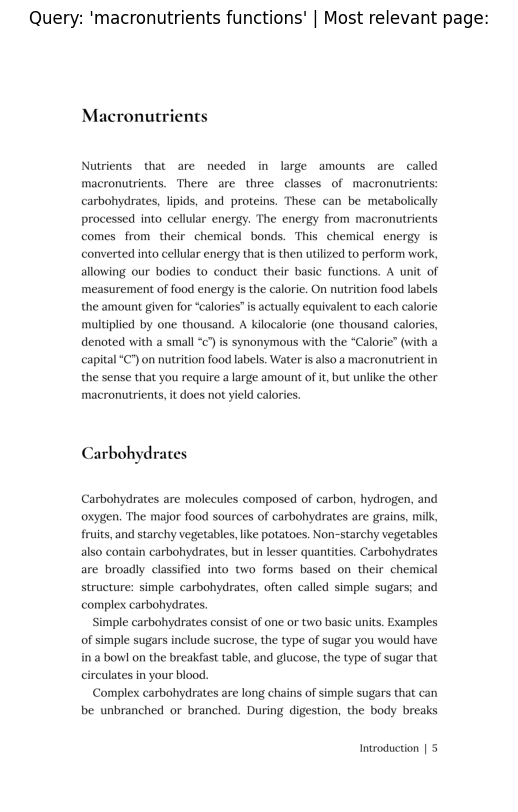

In [54]:
# more robust pipeline

import fitz # pymupdf lib

# automatically surface the page of texts reated to our query - we have page number, so we can display the page from pdf

pdf_path = "human-nutrition-text.pdf"

doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # page numbers start at 41+

# get image of page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# convert pixmap to np array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# display the image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

### Similarity measures: dot product and cosine similarity

Vector dot product v/s cosine similarity 
- closer vectors have higher scores, farther away have lower scores
- in cosine similarity - vector get normalized by magnitude and focus more on directions

### Semantic search pipeline

In [58]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    '''
    Embeds a query with model and returns top k scores and indices from embeddings.
    '''

    # embed query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # get dot product scores
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                k=n_resources_to_return)
    
    return scores, indices


def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [59]:
query = "lack of vitamins"

scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
print_top_results_and_scores(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1679 embeddings: 0.00950 seconds.
[INFO] Time taken to get scores on 1679 embeddings: 0.00018 seconds.
Query: lack of vitamins

Results:
Score: 0.6107
car. Does it drive faster with a half-tank of gas or a full one?It does not matter; the car drives
just as fast as long as it has gas. Similarly, depletion of B vitamins will cause problems in energy
metabolism, but having more than is required to run metabolism does not speed it up. Buyers of
B-vitamin supplements beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally present in numerous
foods, and many other foods are enriched with them. In the United States, B-vitamin deficiencies are
rare; however in the nineteenth century some vitamin-B deficiencies plagued many people in North
America. Niacin deficiency, also known as pellagra, was prominent in poorer Americans whose main
dietary staple was refined cor

### Getting an LLM for local generation

choice of LLMs - openAI, claude etc

run locally on our own hardware - https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard

In [61]:
# get gpu memory available
# # BUT memory retrieval not available for MPS for mac
# import torch
# gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
# gpu_memory_gb = round(gpu_memory_bytes / (2**30))
# print(f"Available GPU memory: {gpu_memory_gb} GB")

In [78]:
# according to chatgpt - my local machine has 16 GPU cores and 16 GB unified memory ~8–12 GB VRAM allocation
# alternativelym run this on google colab
gpu_memory_gb = 10

if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 10 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


for now, let's try using Gemma 7B-it (instructions tuned)



In [79]:
# let's go ahead with Gemma 2b-it and float16

In [80]:
model_id

'google/gemma-2b-it'

In [81]:
!pip install flash-attn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 412.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      
      
      torch.__version__  = 2.2.2
      
      
      /private/var/folders/g_/q1mhhlqx2kvc2wsjsrmc7kx00000gn/T/pip-install-_uv2cim4/flash-attn_3aca097b71de4ed69027a966d485c7c9/setup.py:99: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/privat

In [84]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Quantization for smaller model loading (optional step, check model id) - configon what precision to load the model
# from transformers import BitsAndBytesConfig
# quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

# 2. set up Flash Attention 2 for faster inference - default to sdpa (scaled dot product attention). if not available
# if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
#   attn_implementation = "flash_attention_2"
# else:
#   attn_implementation = "sdpa"
# print(f"[INFO] Using attention implementation: {attn_implementation}")

attn_implementation = "sdpa"
print(f"[INFO] Using attention implementation: {attn_implementation}")


# 3. tokenizer to convert query + etc into valid input for LLM
model_id = model_id # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
# llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
#                                                  torch_dtype=torch.float16, # datatype to use, we want float16
#                                                  quantization_config=quantization_config if use_quantization_config else None,
#                                                  low_cpu_mem_usage=False, # use full memory 
#                                                  attn_implementation=attn_implementation) # which attention version to use

# for macOS
llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    torch_dtype=torch.float32,  # Use float32 as macOS lacks GPU float16 support
    # quantization_config=None,  # Quantization removed due to CUDA dependency
    low_cpu_mem_usage=True,  # Optimize for CPU
    attn_implementation=attn_implementation
)

device = torch.device("mps" if torch.has_mps else "cpu")  # Use Apple's Metal Performance Shaders if available
llm_model.to(device)
print(f"[INFO] Model moved to device: {device}")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2b-it


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

loading file tokenizer.model from cache at /Users/aaryanpotdar/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/96988410cbdaeb8d5093d1ebdc5a8fb563e02bad/tokenizer.model
loading file tokenizer.json from cache at /Users/aaryanpotdar/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/96988410cbdaeb8d5093d1ebdc5a8fb563e02bad/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /Users/aaryanpotdar/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/96988410cbdaeb8d5093d1ebdc5a8fb563e02bad/special_tokens_map.json
loading file tokenizer_config.json from cache at /Users/aaryanpotdar/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/96988410cbdaeb8d5093d1ebdc5a8fb563e02bad/tokenizer_config.json


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/aaryanpotdar/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/96988410cbdaeb8d5093d1ebdc5a8fb563e02bad/config.json
Model config GemmaConfig {
  "_name_or_path": "google/gemma-2b-it",
  "architectures": [
    "GemmaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "eos_token_id": 1,
  "head_dim": 256,
  "hidden_act": "gelu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 16384,
  "max_position_embeddings": 8192,
  "model_type": "gemma",
  "num_attention_heads": 8,
  "num_hidden_layers": 18,
  "num_key_value_heads": 1,
  "pad_token_id": 0,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "torch_dtype": "float32",
  "transformers_version": "4.38.2",
  "use_cache": true,
  "vocab_size": 256000
}



model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /Users/aaryanpotdar/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/96988410cbdaeb8d5093d1ebdc5a8fb563e02bad/model.safetensors.index.json


model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Instantiating GemmaForCausalLM model under default dtype torch.float32.
Generate config GenerationConfig {
  "bos_token_id": 2,
  "eos_token_id": 1,
  "pad_token_id": 0
}



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing GemmaForCausalLM.

All the weights of GemmaForCausalLM were initialized from the model checkpoint at google/gemma-2b-it.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GemmaForCausalLM for predictions without further training.


generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /Users/aaryanpotdar/.cache/huggingface/hub/models--google--gemma-2b-it/snapshots/96988410cbdaeb8d5093d1ebdc5a8fb563e02bad/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 2,
  "eos_token_id": 1,
  "pad_token_id": 0
}

/var/folders/g_/q1mhhlqx2kvc2wsjsrmc7kx00000gn/T/ipykernel_136/3906649010.py:43: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")  # Use Apple's Metal Performance Shaders if available


[INFO] Model moved to device: mps


In [85]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

In [86]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2506172416

about 2.5 billion parameters

In [88]:
# get the model's memory requirements:

def get_model_mem_size(model: torch.nn.Module):
    '''
    https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    '''
    # get model parameters and buffer sizes:
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # calculate model size:
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 10091798528, 'model_mem_mb': 9624.29, 'model_mem_gb': 9.4}

In [89]:
# here model takes 9.4 gb on GPU + some for forward pass due to calculations between layers

### Generating Text

note that some models are trained to generate text with a specific input template in mind.

NOTE - further exploration (fine tuning of LLM)

In [90]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# prompt template for instruction tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# apply chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep raw text
                                       add_generation_prompt=True)

print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [98]:
!pip install git+https://github.com/huggingface/transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/huggingface/transformers to /private/var/folders/g_/q1mhhlqx2kvc2wsjsrmc7kx00000gn/T/pip-req-build-ctqgm6s_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /private/var/folders/g_/q1mhhlqx2kvc2wsjsrmc7kx00000gn/T/pip-req-build-ctqgm6s_
  Resolved https://github.com/huggingface/transformers to commit cdca3cf9e361a009b615f842f5dbc11d244f3cdc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached tokenizers-0.21.0-cp39-abi3-macosx_10_12_x86_64.whl.metadata (6.7 kB)
Using cached tokenizers-0.21.0-cp39-abi3-macosx_10_12_x86_64.whl (2.6 MB)
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10314652 sha256=8bb8ef04bf01bd57ed6ac37b4529b03baa7ff5ed2665399d0cfc474838eb8514
  Stored in directory: /private/var/folders/g_/q1mhhlqx2kvc2wsjsrmc7kx00000gn/T/pip-ephem-wheel-cache-a3qaj6l8/wh

In [114]:
%%time

device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
print(f"[INFO] Using device: {device}")

# next step: tokeniz and pass it to model's tokenize function
input_ids = tokenizer(prompt, return_tensors="pt").to(device)
print(f"Model input (tokenized):\n{input_ids}\n")

llm_model = llm_model.to(device)

# # generate output based on tokenized input:
# llm_model = llm_model.to(device)
# note, autocast is not supported in mac
outputs = llm_model.generate(**input_ids, max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")                           

[INFO] Using device: cpu
Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]])}



KeyboardInterrupt: 

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")